In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

In order to connect to our database, follow the steps below. Let Seth (seth@sethpeterson.net) know if you need the database connection url. 

    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). 

Read in data

In [2]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
ratings = tr.reviews_vector()[['listingID','num_reviews', 'rating']]
tr.close() #Be sure to call close() when you're done so it terminates the connection to the DB.

Merge data frames 

In [3]:
#merge our properties, geo, and rating df on listingID
df = pd.merge(geo, prop, on='listingID')
df = pd.merge(df, ratings, on='listingID', how='left')

In [4]:
df = df[df['num_reviews'] > 10]
df.dropna(subset=['zipcode'], inplace=True)

In [5]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,Keypad,Elevator,Smart lock,Microwave,translation missing: en.hosting_amenity_50,Carbon monoxide detector,Extra pillows and blankets,Laptop friendly workspace,num_reviews,rating
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,11,100.0
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,36,94.0
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,69,91.0
5,4197,20003.0,38.88791,-76.99668,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,39,97.0
6,4529,20019.0,38.90645,-76.94305,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,99,93.0


In [6]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

## Feature Selection

In [7]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'beds', 'Guest suite', 'Entire home/apt', 'Private room', 'Shared room', 'Dryer', 'Paid parking off premises', 'Washer', 'Indoor fireplace', '24-hour check-in', 'TV', 'Internet', 'Free street parking', 'Gym', 'Free parking on premises', 'Family/kid friendly', 'Cable TV', 'First aid kit', 'Lock on bedroom door', 'Self check-in', 'Elevator', 'rating']


In [8]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'Entire home/apt', 'Dryer', 'Indoor fireplace', '24-hour check-in', 'Internet', 'Free street parking', 'Gym', 'Free parking on premises', 'Family/kid friendly', 'Cable TV', 'Lock on bedroom door', 'Elevator', 'num_reviews', 'rating']


In [9]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Edgewood, Bloomingdale, Truxton Circle, Eckington', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Ivy City, Arboretum, Trinidad, Carver Langston', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'North Cleveland Park, Forest Hills, Van Ness', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU', 'bathrooms', 'bedrooms', 'Apartment', 'Guest suite', 'Serviced apartment', 'Entire home/apt', 'Shared room']


In [10]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

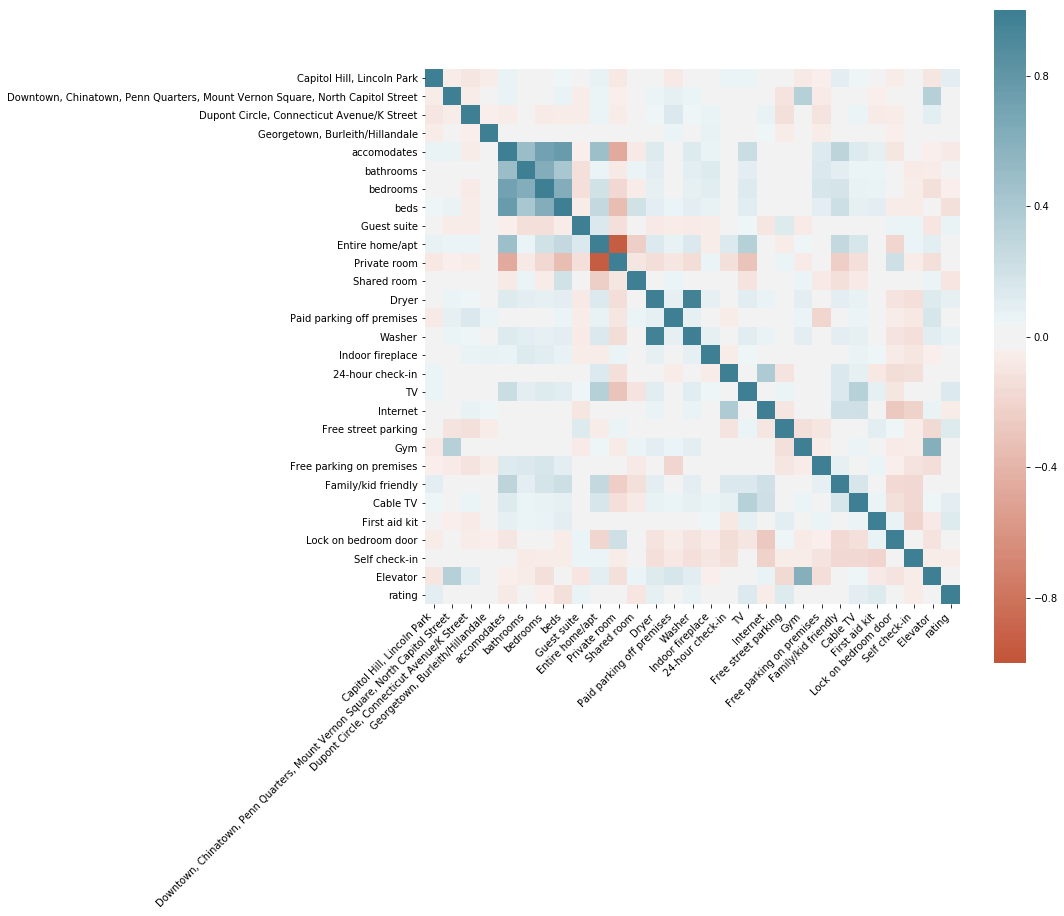

In [11]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('feature_correlation_heatmap.png', dpi=100)

Chi-squared (chi²) statistical test for non-negative features to select 20 of the best features

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#drop geo data in the feature selection because Chi2 only works for non-negative features
featureswithoutgeo = features[features.columns.drop(['longitude'])]

#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(featureswithoutgeo,label)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(featureswithoutgeo.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                                                 Specs         Score
104                                        num_reviews  27183.566869
30                                         accomodates   2473.582634
42                                         Shared room   2128.129306
33                                                beds   1618.942310
41                                        Private room   1342.079583
38                                  Serviced apartment   1282.085411
32                                            bedrooms   1052.020329
10   Downtown, Chinatown, Penn Quarters, Mount Vern...    827.206153
5      Capitol View, Marshall Heights, Benning Heights    771.429540
52                                                Pool    671.943591
83                                                 Gym    660.933201
40                                     Entire home/apt    650.559290
28                         West End, Foggy Bottom, GWU    630.330009
65                               W

Feature Importance

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 20 features for the dataset.

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.03350102 0.05207693 0.05014409 0.00616589 0.00325663 0.00838989
 0.00096813 0.00197156 0.0018692  0.01011592 0.0011749  0.00349324
 0.00732134 0.01095105 0.00159663 0.00390398 0.00634418 0.00447248
 0.004642   0.00204912 0.00086339 0.0007344  0.00174458 0.00756214
 0.00183738 0.00141542 0.00223955 0.00190767 0.01091083 0.00264171
 0.00141152 0.0329591  0.01688169 0.02128795 0.02599776 0.01100367
 0.00645837 0.00513003 0.00762894 0.00149313 0.00990596 0.00515598
 0.00505709 0.00198861 0.00844218 0.00968986 0.01566924 0.00705644
 0.00085773 0.00164815 0.00528709 0.00850808 0.00670038 0.00390325
 0.00367261 0.01757162 0.00143029 0.00474404 0.01001278 0.01873998
 0.00115746 0.00456967 0.01407535 0.00401304 0.00303218 0.01404944
 0.00319725 0.01250525 0.00046212 0.00227706 0.00876907 0.00197215
 0.01238972 0.00143509 0.00228213 0.01647223 0.00932889 0.00383359
 0.02057937 0.0193529  0.00497145 0.00202769 0.00218328 0.01112654
 0.00572195 0.00596959 0.01914951 0.01974276 0.00795598 0.0139

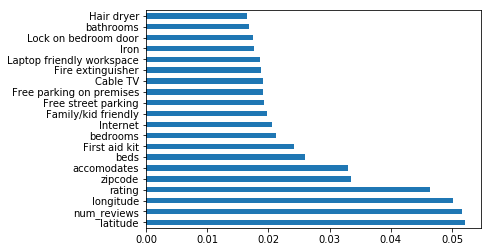

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(features,label)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Model Evaluation with top 20 features

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [15]:
Top20Features = [
    'latitude',
    'num_reviews',
    'longitude',
    'rating',
    'accomodates',
    'zipcode',
    'beds',
    'First aid kit',
    'bedrooms',
    'Free street parking',
    'Internet',
    'Lock on bedroom door',
    'Family/kid friendly',
    'Free parking on premises',
    'Iron',                         
    'bathrooms',                   
    'Fire extinguisher',          
    'Laptop friendly workspace',    
    'Hair dryer',         
    'Cable TV',
]

X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(features[Top20Features], label, test_size=0.2)

regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection)))
print(regr.score(X_test_featureSelection,y_test_featureSelection))

1936.6372426165435
0.5146412938638106


## Remove features with high correlations
Quick Model Comparison Between Models with highly correlated features vs without

In [16]:
featuresWithoutHighCorrFeature = features[features.columns.drop(['bedrooms', 'beds', 'Private room','Elevator','Dryer'])]

In [17]:
#Split without highly correlated features
X_train_featureSelection, X_test_featureSelection, y_train_featureSelection, y_test_featureSelection = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)
#Split with all features
X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)

In [18]:
regr = LinearRegression()
regr.fit(X_train_featureSelection,y_train_featureSelection)
print('The mean squared error for model without highly correlated feature: ' + str(mean_squared_error(y_test_featureSelection, regr.predict(X_test_featureSelection))))
print('The r2 for model without highly correlated feature: ' + str(regr.score(X_test_featureSelection, y_test_featureSelection)))

regr = LinearRegression()
regr.fit(X_train,y_train)
print('The mean squared error for model with all features: ' + str(mean_squared_error(y_test, regr.predict(X_test))))
print('The r2 for model with all featuers: '+ str(regr.score(X_test,y_test)))

The mean squared error for model without highly correlated feature: 1622.812472255609
The r2 for model without highly correlated feature: 0.6148497452291756
The mean squared error for model with all features: 1681.2159340038481
The r2 for model with all featuers: 0.5974582433416209


# Model Selection

The following models are from Georgetown Data Analytics (CCPE), under the machine learning notebook: https://github.com/georgetown-analytics/machine-learning/tree/master/notebook

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(featuresWithoutHighCorrFeature, label, test_size=0.2)

Linear Regression

In [20]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print(mean_squared_error(y_test, lr.predict(X_test)))
print(lr.score(X_test,y_test))

1595.8786433186692
0.6059857377125788


Lasso

In [21]:
lasso_model = Lasso()
lasso_model.fit(X_train,y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_model.predict(X_test))))
print('Lasso R^2: '+ str(lasso_model.score(X_test, y_test)))

Lasso mean squared error: 1953.9046981314189
Lasso R^2: 0.5175909387362807


Ridge

In [22]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_model.predict(X_test))))
print('Ridge R^2: '+ str(ridge_model.score(X_test, y_test)))

Ridge mean squared error: 1607.382451115166
Ridge R^2: 0.6031455064948672


Hyperparameter tuning

Ridge

In [23]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.00757525025877192


In [30]:
ridge_a = Ridge(alpha=0.00757525025877192)
ridge_a.fit(X_train, y_train)
print('Ridge mean squared error: '+ str(mean_squared_error(y_test, ridge_a.predict(X_test))))
print('Ridge R^2: '+ str(ridge_a.score(X_test, y_test)))

Ridge mean squared error: 1595.6109189364918
Ridge R^2: 0.6060518374911439


Lasso

In [25]:
from sklearn.model_selection import GridSearchCV


lasso = Lasso(random_state=0)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_params = [{'alpha': alphas}]
n_folds = 12

grid = GridSearchCV(
    lasso, tuned_params, cv=n_folds
)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)


In [26]:
lasso_a = Lasso(alpha=0.001)
lasso_a.fit(X_train, y_train)
print('Lasso mean squared error: ' + str(mean_squared_error(y_test, lasso_a.predict(X_test))))
print('Lasso R^2: '+ str(lasso_a.score(X_test, y_test)))

Lasso mean squared error: 1595.1472771561284
Lasso R^2: 0.6061663082717513


Model Evaluation

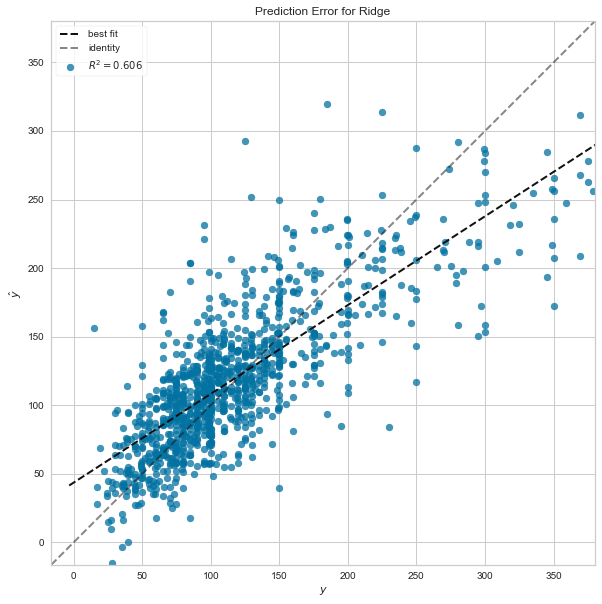

In [27]:
from yellowbrick.regressor import PredictionError

model = Ridge(alpha=0.01)
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

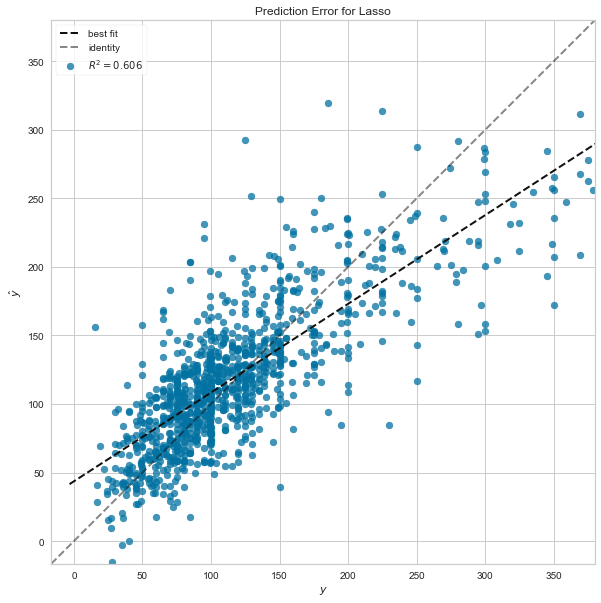

In [28]:
model = Lasso(alpha=0.001)
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Mean cv score: 0.5933966171938009


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.
  % (min_groups, self.n_splits)), Warning)


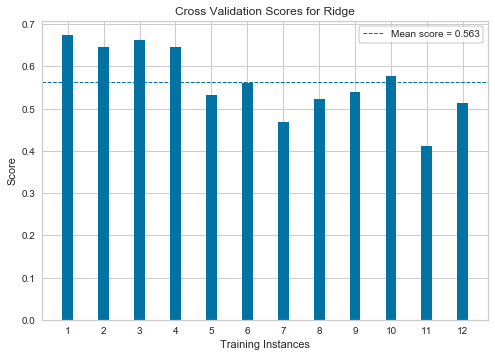

In [43]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from statistics import mean
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ridge_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer = CVScores(ridge_a, cv=cv, scoring='r2')

visualizer.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

Mean cv score: 0.5934865683955066


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=12.
  % (min_groups, self.n_splits)), Warning)


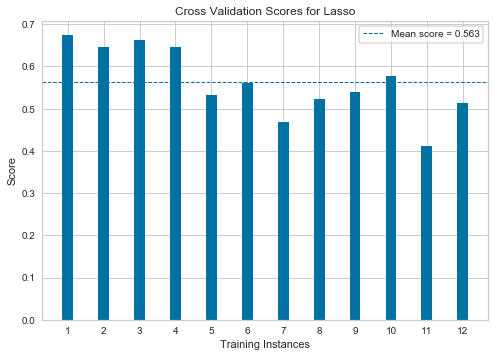

In [44]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from statistics import mean
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lasso_a, featuresWithoutHighCorrFeature, label, cv=12)          

print('Mean cv score: '+ str(mean(scores)))

cv = StratifiedKFold(n_splits=12, random_state=42)
visualizer = CVScores(lasso_a, cv=cv, scoring='r2')

visualizer.fit(featuresWithoutHighCorrFeature.values, label.values)        # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data